In [298]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [299]:
vertics['_id'][0]['$oid']

'617382efacd9177a56bf14e8'

## Тута создаём массивы с вершинами и их типами
Дорога жёлтая, дорога белая, район дороги (порядковая нумерация).

In [300]:
'''
p_type[:, 0] - 1 - если дорога жёлтая, 0 - если серая
p_type[:, 1] - номер района. (-1) - если не определен
'''

vertics = pd.read_json('vertics')
points = np.zeros((vertics.shape[0], 2), dtype=float)
p_type = np.zeros((vertics.shape[0], 2), dtype=int)
p_id = []
for i in range(vertics.shape[0]):
    points[i][0] = vertics['coordinates'][i][0]
    points[i][1] = vertics['coordinates'][i][1]
    p_type[i][0] = 1 if vertics['is_big_node'][i] else 0
    p_type[i][1] = -1
    p_id.append(vertics['_id'][i]['$oid'])
    


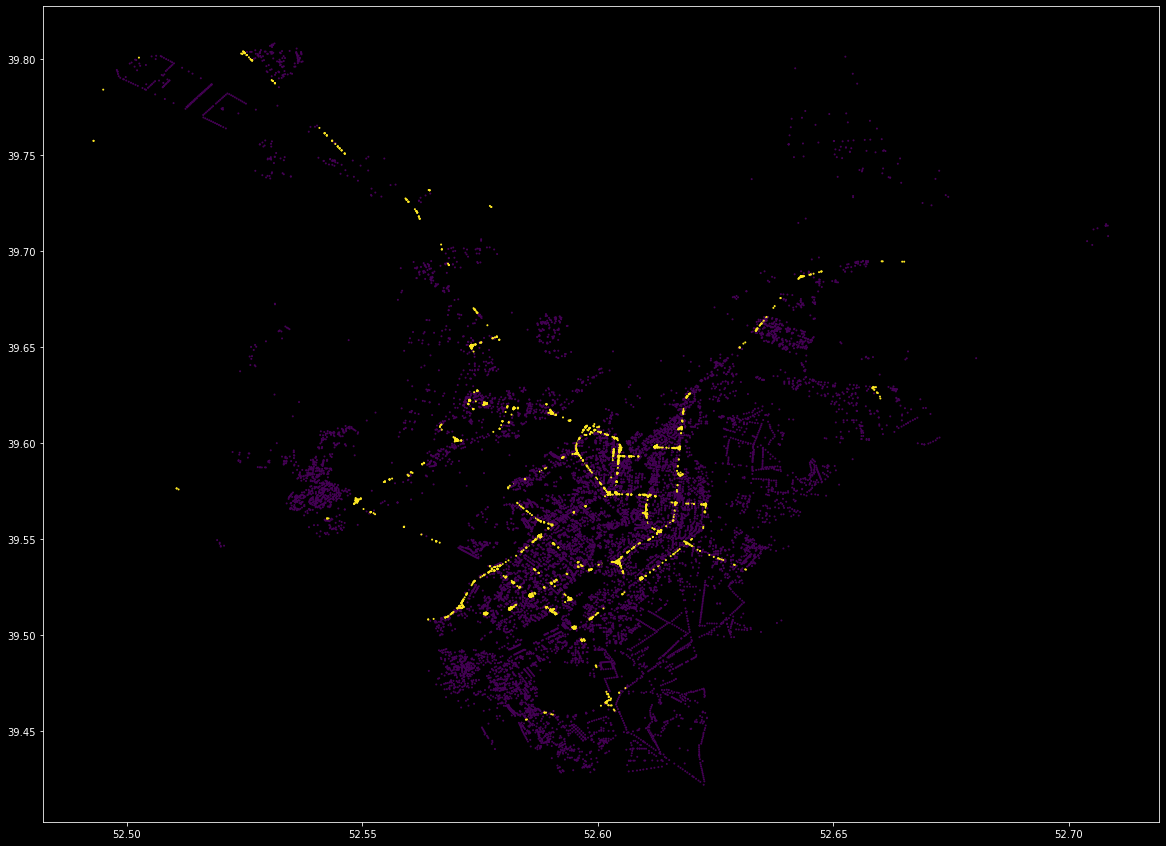

In [301]:
fig = plt.gcf()
fig.set_size_inches(20, 15)

plt.scatter(points[:, 0], points[:, 1], s=1, c=p_type[:,0])

## Тута создаём массивы с вершинами дорог 
Дороги соединяют две точки по ПДД. Разделяем их за нехваткой времени.

In [302]:
roads = pd.read_json('road')
r_in = []
r_out = []
for i in range(roads.shape[0]):
    r_in.append(roads['in_vertics'][i]['vertics_id'])
    r_out.append(roads['out_vertics'][i]['vertics_id'])

## Далее реализуем bfs и распределяем точки по районам

In [303]:
def bfs(v_id, cur_id, p_type, p_id, r_in, r_out):
    _in = 0
    _out = 0
    
    p_type[p_id.index(v_id), 1] = cur_id
    while (True):
        if v_id in r_in[_in:]:
            _in = r_in[_in:].index(v_id)
            v_id_n = r_out[r_in.index(v_id)]
            if p_type[p_id.index(v_id_n)][0] != 1 and p_type[p_id.index(v_id_n)][1] == -1:
                bfs(v_id_n, cur_id, p_type, p_id, r_in, r_out)
                continue
        if v_id in r_out:
            v_id_n = r_in[r_out.index(v_id)]
            if p_type[p_id.index(v_id_n)][0] != 1 and p_type[p_id.index(v_id_n)][1] == -1:
                bfs(v_id_n, cur_id, p_type, p_id, r_in, r_out)
                continue
        break

In [304]:
_id = 0     # id района, к которому определяем дорогу
itero = 0

for v in r_in:
    p_info = p_type[p_id.index(v)]
    
    # если дорога не главная
    # если дорога не определена к району
    if p_info[0] != 1 and p_info[1] == -1:
        bfs(v, _id, p_type, p_id, r_in, r_out)
        _id += 1
        
# for v in r_out:
#     p_info = p_type[p_id.index(v)]
    
#     # если дорога не главная
#     # если дорога не определена к району
#     if p_info[0] != 1 and p_info[1] == -1:
#         bfs(p_id.index(v), _id, p_type, p_id, r_in, r_out)
#         _id += 1

print(len(r_in), _id)

RecursionError: maximum recursion depth exceeded in comparison

In [ ]:
cnt = 0
for v in p_type:
    cnt += 1 if v[1] != -1 else 0
_id

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20, 15)

plt.scatter(points[:, 0], points[:, 1], s=3, c=p_type[:,1])